In [1]:
def get_upos(feat_str):
    # feat_str example: "ud=PROPN|pos=noun_prop|prc3=0|prc2=0|..."
    for feat in feat_str.split('|'):
        if feat.startswith('ud='):
            return feat[len('ud='):]  # Extract "PROPN"
    return None

def extract_features_from_parse(parse_lines):
    """
    Input:
      parse_lines: List[str], lines of the CoNLL-like parse (tokens only, no comment lines)
    Output:
      features: dict with syntactic features
    """
    tokens = []
    heads = []
    deprels = []
    upos_tags = []

    # Parse lines to extract relevant info
    for line in parse_lines:
        if line.startswith('#'):
            continue  # skip comment lines

        parts = line.strip().split('\t')
        if len(parts) < 8:
            continue  # skip malformed lines
        token_id = int(parts[0])
        word = parts[1]
        upos = get_upos(parts[5])
        head = int(parts[6])
        deprel = parts[7]

        tokens.append(word)
        upos_tags.append(upos)
        heads.append(head)
        deprels.append(deprel)

    n = len(tokens)

    # Dependency distances
    dep_distances = [abs((i+1) - head) if head != 0 else 0 for i, head in enumerate(heads)]
    avg_dep_distance = sum(dep_distances) / n if n > 0 else 0
    max_dep_distance = max(dep_distances) if dep_distances else 0
    long_deps_count = sum(d > 3 for d in dep_distances)

    # POS tag counts and ratios
    from collections import Counter
    pos_counts = Counter(upos_tags)

    noun_count = pos_counts.get('NOUN', 0) + pos_counts.get('PROPN', 0)
    verb_count = pos_counts.get('VERB', 0)
    adj_count = pos_counts.get('ADJ', 0)
    adv_count = pos_counts.get('ADV', 0)
    adp_count = pos_counts.get('ADP', 0)
    pron_count = pos_counts.get('PRON', 0)
    cconj_count = pos_counts.get('CCONJ', 0)
    num_count = pos_counts.get('NUM', 0)
    punct_count = pos_counts.get('PUNCT', 0)
    sconj_count = pos_counts.get('SCONJ', 0)
    part_count = pos_counts.get('PART', 0)
    det_count = pos_counts.get('DET', 0)
    aux_count = pos_counts.get('AUX', 0)
    intj_count = pos_counts.get('INTJ', 0)
    pipe_count = pos_counts.get('|', 0)  # assuming '|' shows up in the pos column

    total_content_words = noun_count + verb_count + adj_count + adv_count
    total_words = n

    verb_to_noun_ratio = (verb_count / noun_count) if noun_count > 0 else 0
    content_word_ratio = (total_content_words / total_words) if total_words > 0 else 0

    # Dependency relation counts
    dep_counts = Counter(deprels)
    sbj_count = dep_counts.get('SBJ', 0)
    obj_count = dep_counts.get('OBJ', 0)
    advcl_count = dep_counts.get('ADVCL', 0)
    acl_count = dep_counts.get('ACL', 0)
    conj_count = dep_counts.get('CONJ', 0)
    cc_count = dep_counts.get('CC', 0)

    # Tree structure
    children = {i+1: [] for i in range(n)}
    root = None
    for i, h in enumerate(heads, 1):
        if h == 0:
            root = i
        else:
            children[h].append(i)

    def tree_depth(node):
        if not children[node]:
            return 1
        else:
            return 1 + max(tree_depth(c) for c in children[node])

    max_depth = tree_depth(root) if root else 0

    dependents_counts = [len(children[h]) for h in children]
    avg_dependents = sum(dependents_counts) / n if n > 0 else 0
    max_dependents = max(dependents_counts) if dependents_counts else 0

    # Left and right dependents
    left_deps = sum(1 for i, h in enumerate(heads, 1) if h != 0 and h > i)
    right_deps = sum(1 for i, h in enumerate(heads, 1) if h != 0 and h < i)
    left_right_dep_ratio = (left_deps / right_deps) if right_deps != 0 else 0

    # Compose features
    features = {
        'avg_dep_distance': avg_dep_distance,
        'max_dep_distance': max_dep_distance,
        'long_deps_count': long_deps_count,
        'noun_count': noun_count,
        'verb_count': verb_count,
        'adj_count': adj_count,
        'adv_count': adv_count,
        'adp_count': adp_count,
        'pron_count': pron_count,
        'cconj_count': cconj_count,
        'num_count': num_count,
        'punct_count': punct_count,
        'sconj_count': sconj_count,
        'part_count': part_count,
        'det_count': det_count,
        'aux_count': aux_count,
        'intj_count': intj_count,
        'pipe_count': pipe_count,
        'verb_to_noun_ratio': verb_to_noun_ratio,
        'content_word_ratio': content_word_ratio,
        'sbj_count': sbj_count,
        'obj_count': obj_count,
        'advcl_count': advcl_count,
        'acl_count': acl_count,
        'conj_count': conj_count,
        'cc_count': cc_count,
        'max_depth': max_depth,
        'avg_dependents': avg_dependents,
        'max_dependents': max_dependents,
        'left_deps': left_deps,
        'right_deps': right_deps,
        'left_right_dep_ratio': left_right_dep_ratio,
        'total_words': total_words
    }

    return features


def extract_pos_tags_from_block(block):
    """
    Input:
      block: List[str], lines of the CoNLL-like parse (tokens only, no comment lines)
    Output:
      pos_tags: List[str] with POS tags
    """
    pos_tags = []
    for line in block:
        if line.startswith('#'):
            continue  # skip comment lines

        parts = line.strip().split('\t')
        parts = line.strip().split('\t')
        if len(parts) < 8:
            continue  # skip malformed lines
        upos = get_upos(parts[5])
        if upos:
            pos_tags.append(upos)
        else:
            pos_tags.append('UNKNOWN')

    return pos_tags

def extract_features_from_ud(ud_string):
    """Parse the 'ud=' string and return a dict of features."""
    if not ud_string.startswith('ud='):
        return {}
    feature_string = ud_string
    features = feature_string.split('|')
    feature_dict = {}
    for feat in features:
        if '=' in feat:
            k, v = feat.split('=', 1)
            feature_dict[k] = v
    return feature_dict

def extract_morph_features_from_block(block, all_features):
    """
    Extract morphological features from one CoNLL block.
    Returns: dict of {feature_name: list of values}
    """
    features_by_name = {feat: [] for feat in all_features}
    
    for line in block:
        if line.startswith('#'):
            continue
        parts = line.strip().split('\t')
        if len(parts) < 8:
            continue
        morph_dict = extract_features_from_ud(parts[5])
        for feat in all_features:
            features_by_name[feat].append(morph_dict.get(feat, "na"))  # "na" for missing
    return features_by_name

In [2]:
parse_lines = [
    "# text = أنا أحب أختي",
    "# treeTokens = أنا أحب أخت +ي",
    "1	أنا	أنا	NOM	_	ud=PRON|pos=pron|prc3=0|prc2=0|prc1=0|prc0=0|enc0=0|asp=na|vox=na|mod=na|gen=m|num=s|stt=i|cas=n|per=1|rat=y|token_type=baseword	2	SBJ	_	_",
    "2	أحب	أحب	VRB	_	ud=VERB|pos=verb|prc3=0|prc2=0|prc1=0|prc0=0|enc0=0|asp=i|vox=a|mod=u|gen=m|num=s|stt=na|cas=na|per=1|rat=n|token_type=baseword	0	---	_	_",
    "3	أخت	أخت	NOM	_	ud=NOUN|pos=noun|prc3=0|prc2=0|prc1=0|prc0=0|enc0=0|asp=na|vox=na|mod=na|gen=f|num=s|stt=c|cas=u|per=na|rat=r|token_type=baseword	2	OBJ	_	_",
    "4	+ي	+ي	NOM	_	ud=PRON|pos=pron|prc3=0|prc2=0|prc1=0|prc0=0|enc0=0|asp=na|vox=na|mod=na|gen=m|num=s|stt=d|cas=g|per=1|rat=na|token_type=enc0	3	IDF	_	_",
    ]

features = extract_features_from_parse(parse_lines)
print(features)

sentence = parse_lines[0].replace("# text = ", "").strip()
print(sentence)  # Output: أنا أحب أختي

{'avg_dep_distance': 0.75, 'max_dep_distance': 1, 'long_deps_count': 0, 'noun_count': 1, 'verb_count': 1, 'adj_count': 0, 'adv_count': 0, 'adp_count': 0, 'pron_count': 2, 'cconj_count': 0, 'num_count': 0, 'punct_count': 0, 'sconj_count': 0, 'part_count': 0, 'det_count': 0, 'aux_count': 0, 'intj_count': 0, 'pipe_count': 0, 'verb_to_noun_ratio': 1.0, 'content_word_ratio': 0.5, 'sbj_count': 1, 'obj_count': 1, 'advcl_count': 0, 'acl_count': 0, 'conj_count': 0, 'cc_count': 0, 'max_depth': 3, 'avg_dependents': 0.75, 'max_dependents': 2, 'left_deps': 1, 'right_deps': 2, 'left_right_dep_ratio': 0.5, 'total_words': 4}
أنا أحب أختي


# Try that on the whole dataset and simple model

In [3]:
import re
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.utils.dediac import dediac_ar
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.utils.charmap import CharMapper

arclean = CharMapper.builtin_mapper("arclean")

def clean_broken_arabic_words(text):
    """ Clean broken Arabic words and remove tatweel characters."""
    
    def clean_line(line, arclean):
        return simple_word_tokenize(arclean(dediac_ar(normalize_unicode(line.strip()))))
    
    # Step 1: Remove broken words
    text = text.replace(' ـ', '')
    text = text.replace('ـ ', '')

    # use camel tools to clean the text, it removes tatweel characters and diacritics
    text = " ".join(clean_line(text, arclean))
    return text

def clean_sentence(sentence):

    # # Arabic characters range: main + extended + some punctuation
    # arabic_pattern = re.compile(r'[\u0600-\u06FF]+')

    # # Extract all Arabic tokens
    # arabic_tokens = arabic_pattern.findall(sentence)

    # sentence = " ".join(arabic_tokens)
    sentence = clean_broken_arabic_words(sentence)

    # If sentence ends with arabic comma '،', remove it because it mess up with dependency parsing
    if sentence.endswith('،'):
        sentence = sentence[:-1].strip()

    # Remove extra spaces
    sentence = re.sub(r'\s+', ' ', sentence).strip()
        
    # Join with space to reconstruct a clean sentence
    return sentence

def clean_example(example):
    example["Sentence"] = clean_sentence(example["Sentence"])
    return example

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # or XGBoost if you want
from sklearn.metrics import classification_report
from datasets import load_dataset
import pyarabic.araby as araby

# Load sentence-level data from the "Dev" split
train_dataset = load_dataset("CAMeL-Lab/BAREC-Shared-Task-2025-sent", split="train")
eval_dataset = load_dataset("CAMeL-Lab/BAREC-Shared-Task-2025-sent", split="validation")
test_dataset = load_dataset("CAMeL-Lab/BAREC-Shared-Task-2025-sent", split="test")

# Fix labels to be 0-indexed
train_dataset = train_dataset.map(lambda x: {"labels": x["Readability_Level_19"] - 1, "Sentence": araby.strip_diacritics(x["Sentence"])})
eval_dataset = eval_dataset.map(lambda x: {"labels": x["Readability_Level_19"] - 1, "Sentence": araby.strip_diacritics(x["Sentence"])})
test_dataset = test_dataset.map(lambda x: {"labels": x["Readability_Level_19"] - 1, "Sentence": araby.strip_diacritics(x["Sentence"])})

# we should always clean each sentence in the dataset to be able to join with features
train_dataset = train_dataset.map(clean_example)
eval_dataset = eval_dataset.map(clean_example)
test_dataset = test_dataset.map(clean_example)

df = pd.DataFrame(train_dataset)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [2]:
train_dataset, eval_dataset, test_dataset

(Dataset({
     features: ['ID', 'Sentence', 'Word_Count', 'Readability_Level', 'Readability_Level_19', 'Readability_Level_7', 'Readability_Level_5', 'Readability_Level_3', 'Annotator', 'Document', 'Source', 'Book', 'Author', 'Domain', 'Text_Class', 'labels'],
     num_rows: 54845
 }),
 Dataset({
     features: ['ID', 'Sentence', 'Word_Count', 'Readability_Level', 'Readability_Level_19', 'Readability_Level_7', 'Readability_Level_5', 'Readability_Level_3', 'Annotator', 'Document', 'Source', 'Book', 'Author', 'Domain', 'Text_Class', 'labels'],
     num_rows: 7310
 }),
 Dataset({
     features: ['ID', 'Sentence', 'Word_Count', 'Readability_Level', 'Readability_Level_19', 'Readability_Level_7', 'Readability_Level_5', 'Readability_Level_3', 'Annotator', 'Document', 'Source', 'Book', 'Author', 'Domain', 'Text_Class', 'labels'],
     num_rows: 7286
 }))

In [88]:
Split = "train"  # or "test" or "train" or "validation"

if Split == "test":
    dataset = test_dataset
elif Split == "validation":
    dataset = eval_dataset
else:
    dataset = train_dataset

In [89]:
from datasets import Dataset

# Convert to pandas first
df = dataset.to_pandas()

# Drop duplicates by sentence
df_unique = df.drop_duplicates(subset=["Sentence"])

# Convert back to Hugging Face Dataset if needed
dataset = Dataset.from_pandas(df_unique)

In [90]:
dataset.shape

(51630, 17)

In [91]:
import os
import math
import numpy as np

N_SPLITS = 10  # Number of chunks
OUTPUT_DIR = "./splits_{}".format(Split)  # Directory to save splits
os.makedirs(OUTPUT_DIR, exist_ok=True)

chunk_size = len(dataset) // N_SPLITS
subsets = []

for i in range(N_SPLITS):
    start = i * chunk_size
    # Make last chunk include all remaining elements
    end = (i + 1) * chunk_size if i < N_SPLITS - 1 else len(dataset)
    subsets.append(dataset.select(range(start, end)))

# Step 2: Process each chunk
N_SPLITS_PER_CHUNK = 1  # Number of sub-chunks per problematic chunk

# for i, cleaned_subset in enumerate(subsets):
#     subset_len = len(cleaned_subset)
#     chunk_size = math.ceil(subset_len / N_SPLITS_PER_CHUNK)

#     for j in range(N_SPLITS_PER_CHUNK):
#         start_idx = j * chunk_size
#         end_idx = min((j + 1) * chunk_size, subset_len)
#         sub_chunk = cleaned_subset.select(range(start_idx, end_idx))

#         # Save sentences
#         input_path = os.path.join(OUTPUT_DIR, f"sentences_{i}_{j+1}.txt")
#         with open(input_path, "w", encoding="utf-8") as f:
#             for sent in sub_chunk["Sentence"]:
#                 f.write(sent.strip() + "\n")

#         # Run CLI tool
#         output_path = os.path.join(OUTPUT_DIR, f"output_{i}_{j+1}.txt")
#         os.system(f"python text_to_conll_cli.py -f text -i {input_path} > {output_path}")


In [92]:
def get_each_output_from_file(filepath):
    blocks = []
    current_block = []
    in_block = False

    with open(filepath, encoding="utf-8") as f:
        for line in f:
            line = line.strip()

            # Start of a new block
            if line.startswith("# text = "):
                if current_block:  # Save previous block if one is in progress
                    blocks.append(current_block)
                current_block = [line]
                in_block = True

            # Skip treeTokens lines
            elif line.startswith("# treeTokens"):
                continue

            # Inside a block, add lines until empty line
            elif in_block:
                if line == "":
                    blocks.append(current_block)
                    current_block = []
                    in_block = False
                else:
                    current_block.append(line)

        # Add last block if file doesn’t end with an empty line
        if current_block:
            blocks.append(current_block)

    return blocks

all_parsed_blocks = []

# get all files that start with "output_" and end with ".txt"
import os
output_files = [f for f in os.listdir(OUTPUT_DIR) if f.startswith("output_") and f.endswith(".txt")]
for output_file in output_files:
    print(f"Processing {output_file}...")
    filepath = os.path.join(OUTPUT_DIR, output_file)
    blocks = get_each_output_from_file(filepath)
    all_parsed_blocks.extend(blocks)
    
# Now `all_parsed_blocks` contains everything from all output files
print(f"Total parsed blocks: {len(all_parsed_blocks)}")

Processing output_0_1.txt...
Processing output_2_1.txt...
Processing output_6_1.txt...
Processing output_4_1.txt...
Processing output_3_1.txt...
Processing output_1_1.txt...
Processing output_5_1.txt...
Processing output_7_1.txt...
Processing output_9_1.txt...
Processing output_8_1.txt...
Total parsed blocks: 51630


In [47]:
# write all_parsed_blocks into a file all_parsed_blocks.txt
with open(f"{OUTPUT_DIR}/all_parsed_blocks_{Split}.txt", "w", encoding="utf-8") as f:
    for block in all_parsed_blocks:
        for line in block:
            f.write(line + "\n")
        f.write("\n")  # Separate blocks with an empty line

In [48]:
def extract_sentence_from_block(block):
    if block and block[0].startswith("# text ="):
        return block[0].replace("# text = ", "").strip()
    return None

features_list = []
for block in all_parsed_blocks:
    sentence = extract_sentence_from_block(block)
    if sentence is not None:
        feats = extract_features_from_parse(block)
        feats["Sentence"] = sentence  # Clean the sentence to match while joining
        features_list.append(feats)

# write features_list to a file features_list.json, its a list of dicts
import json
with open(f"{OUTPUT_DIR}/features_list_{Split}.json", "w", encoding="utf-8") as f:
    json.dump(features_list, f, ensure_ascii=False, indent=4)
    

features_list

[{'avg_dep_distance': 1.0,
  'max_dep_distance': 2,
  'long_deps_count': 0,
  'noun_count': 5,
  'verb_count': 0,
  'adj_count': 0,
  'adv_count': 0,
  'adp_count': 0,
  'pron_count': 0,
  'cconj_count': 1,
  'num_count': 0,
  'punct_count': 0,
  'sconj_count': 0,
  'part_count': 0,
  'det_count': 0,
  'aux_count': 0,
  'intj_count': 0,
  'pipe_count': 0,
  'verb_to_noun_ratio': 0.0,
  'content_word_ratio': 0.8333333333333334,
  'sbj_count': 0,
  'obj_count': 1,
  'advcl_count': 0,
  'acl_count': 0,
  'conj_count': 0,
  'cc_count': 0,
  'max_depth': 5,
  'avg_dependents': 0.8333333333333334,
  'max_dependents': 2,
  'left_deps': 0,
  'right_deps': 5,
  'left_right_dep_ratio': 0.0,
  'total_words': 6,
  'Sentence': 'مجلة كل الأولاد وكل البنات'},
 {'avg_dep_distance': 0.0,
  'max_dep_distance': 0,
  'long_deps_count': 0,
  'noun_count': 1,
  'verb_count': 0,
  'adj_count': 0,
  'adv_count': 0,
  'adp_count': 0,
  'pron_count': 0,
  'cconj_count': 0,
  'num_count': 0,
  'punct_count': 0,


In [49]:
# extract all pos tags with sentence from all_parsed_blocks and save sentence as key, pos tags as value
pos_tags_dict = {}
for block in all_parsed_blocks:
    sentence = extract_sentence_from_block(block)
    sentence = sentence
    if sentence is not None:
        pos_tags = extract_pos_tags_from_block(block)
        pos_tags_dict[sentence] = pos_tags

# save file to pos_tags_dict.json
with open(f"{OUTPUT_DIR}/pos_tags_dict_{Split}.json", "w", encoding="utf-8") as f:
    import json
    json.dump(pos_tags_dict, f, ensure_ascii=False, indent=4)

In [50]:
# Features you want to extract
all_features = [
    "ud", "prc3", "prc2", "prc1", "prc0", "enc0", "gen", "num", "cas", "per", "asp", "vox", "mod", "stt", "rat", "token_type"
]

# Main loop over blocks
morph_features_dict = {}
for block in all_parsed_blocks:
    sentence = extract_sentence_from_block(block)
    if sentence is not None:
        morph_features = extract_morph_features_from_block(block, all_features)
        morph_features_dict[sentence] = morph_features

# Save to JSON
output_path = os.path.join(OUTPUT_DIR, f"morph_features_dict_{Split}.json")
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(morph_features_dict, f, ensure_ascii=False, indent=4)

print(f"Saved morphological features to {output_path}")

Saved morphological features to ./splits_train/morph_features_dict_train.json


In [93]:
# TODO:: very important when joining -> 
# replace the arabic punctuation marks with english ? 
# add space after the arabic punctuation marks if not already there

def build_dep_graph(block):
    """
    Build a dependency graph from a CoNLL block.
    Returns: dict with nodes and edges
    """
    def get_token_type(feat_str):
        if feat_str == "_" or feat_str.strip() == "":
            return {}
        all_feats = dict(item.split("=") for item in feat_str.split("|") if "=" in item)
        return all_feats.get('token_type', 'baseword')  # Default to 'baseword' if not found
    
    sentence = extract_sentence_from_block(block)
    
    if sentence is None:
        return {'nodes': [], 'edges': []}
    
    lines = block[1:]  # Skip the first line which is the sentence line

    tokens_data = []
    for line in lines:
        parts = line.split('\t')
        token_id = int(parts[0])
        form = parts[1]
        if "NOAN" in form:
            # replace "NOAN" with the next part, also replace only "NOAN" not the whole, since for example we have "الNOAN" زنا -> should be "الزنا"
            form = form.replace("NOAN", parts[2])
        head = parts[6]
        dep = parts[7]
        pos_tag = get_upos(parts[5])
        token_type = get_token_type(parts[5])  # Extract token type from the features
        
        tokens_data.append({
            'id': token_id,
            'form': form,
            'head': head,
            'dep': dep,
            'token_type': token_type,
            'pos_tag': pos_tag,  # Add POS tag to the token data
        })

    merged_results = []
    current_word_tokens = []
    current_word_form = ""
    current_word_tokens_contain_baseword = False  # Track if the current word contains a baseword
    map_english_punctuation = {
        ";": ["؛"],  # Arabic semicolon
        ",": ["،", "٫"],  # Arabic comma
        "?": ["؟"],  # Arabic question mark
        "%": ["٪"],  # Arabic percentage sign
        "*": ["۝"],  # Arabic symbol for verse end
    }
    # map_english_punctuation_values = [punct for puncts in map_english_punctuation.values() for punct in puncts]
    # count all the punctuations found in sentence
    punctuations_occurences = []
    for i, letter in enumerate(sentence):
        if letter in map_english_punctuation.keys():
            punctuations_occurences.append(i)

    # Add space after the arabic punctuation marks if its directly attached to the next word
    offset = 0
    for index in punctuations_occurences:
        adjusted_index = index + offset
        if adjusted_index < len(sentence) - 1 and sentence[adjusted_index + 1] != ' ':
            sentence = sentence[:adjusted_index + 1] + ' ' + sentence[adjusted_index + 1:]
            offset += 1  # Adjust offset due to inserted space


    # print(f"Processed sentence: {sentence}")

    # count all the punctuations found in sentence again after adding spaces
    punctuations_occurences = []
    for i, letter in enumerate(sentence):
        if letter in map_english_punctuation.keys():
            punctuations_occurences.append(i)

    print(f"Total punctuations found in sentence: {[sentence[pun] for pun in punctuations_occurences]}")

    current_punctuations_index = 0

    for token in tokens_data:
        form = token['form']
        token_type = token['token_type']
        
        if token_type.startswith('prc'):
            # means a new word is getting started, we need to save the previous word if exists
            if current_word_tokens and current_word_tokens_contain_baseword:
                # Only save if the current word is a baseword
                merged_results.append({
                    'word': current_word_form,
                    'token_ids': [t['id'] for t in current_word_tokens],
                    'heads': [t['head'] for t in current_word_tokens],
                    'deps': [t['dep'] for t in current_word_tokens],
                    'pos_tags': [t['pos_tag'] for t in current_word_tokens],
                    'merged_form': "".join([t['form'].lstrip('+').rstrip('+') for t in current_word_tokens]),
                })
                # Reset current word group
                current_word_tokens = []
                current_word_form = ""

            # Start new word group
            current_word_tokens_contain_baseword = False
            current_word_tokens.append(token)
            current_word_form += form.lstrip('+').rstrip('+')
            
            continue

        if token_type == 'baseword':
            # special case for ";" baseword, sometimes its combined with previous word
            
            if form in map_english_punctuation.keys():
                # we need first to check if its really combined with previous word, need to add all of its properties too
                
                # get the occurence of the punctuation in the sentence
                if current_punctuations_index < len(punctuations_occurences):
                    punctuation_index = punctuations_occurences[current_punctuations_index]
                else:
                    raise Exception(f"Current punctuations index {current_punctuations_index} is out of bounds for sentence: {sentence}")

                # Check if the punctuation is concatenated directly to the previous/next word, or there is a space before it
                # case where the punctuation is directly attached to the next word
                if (punctuation_index < len(sentence) - 1 and sentence[punctuation_index + 1] != ' '):
                    raise Exception(f"Unexpected punctuation '{form}' at index {punctuation_index} in sentence: {sentence}")
                
                if (punctuation_index > 0 and sentence[punctuation_index - 1] != ' '):
                    # print(f"Found '{current_word_form + map_english_punctuation[form]}' in sentence, merging...")
                    # If the current word is part of the sentence, we merge it
                    current_word_tokens.append(token)
                    current_word_form += form.lstrip('+').rstrip('+')

                    # Save previous word if exists
                    if current_word_tokens:
                        merged_results.append({
                            'word': current_word_form,
                            'token_ids': [t['id'] for t in current_word_tokens],
                            'heads': [t['head'] for t in current_word_tokens],
                            'deps': [t['dep'] for t in current_word_tokens],
                            'pos_tags': [t['pos_tag'] for t in current_word_tokens],
                            'merged_form': "".join([t['form'].lstrip('+').rstrip('+') for t in current_word_tokens]),
                        })
                    # Start new word group
                    current_word_tokens = []
                    current_word_form = ""
                    current_word_tokens_contain_baseword = False
                    # increment current_punctuations_index
                    current_punctuations_index += 1
                    continue
                else:
                    # increment current_punctuations_index
                    current_punctuations_index += 1

            # Save previous word if exists
            if current_word_tokens and current_word_tokens_contain_baseword:
                # Only save if the current word is a baseword
                merged_results.append({
                    'word': current_word_form,
                    'token_ids': [t['id'] for t in current_word_tokens],
                    'heads': [t['head'] for t in current_word_tokens],
                    'deps': [t['dep'] for t in current_word_tokens],
                    'pos_tags': [t['pos_tag'] for t in current_word_tokens],
                    'merged_form': "".join([t['form'].lstrip('+').rstrip('+') for t in current_word_tokens]),
                })
                # Reset current word group
                current_word_tokens = []
                current_word_form = ""

            # Start new word group
            current_word_tokens_contain_baseword = True
            current_word_tokens.append(token)
            current_word_form += form.lstrip('+').rstrip('+')
        else:
            # Add clitic or enc0 tokens to current word group
            current_word_tokens.append(token)
            current_word_form += form.lstrip('+').rstrip('+')

    # Append last word group after loop
    if current_word_tokens:
        merged_results.append({
            'word': current_word_form,
            'token_ids': [t['id'] for t in current_word_tokens],
            'heads': [t['head'] for t in current_word_tokens],
            'deps': [t['dep'] for t in current_word_tokens],
            'pos_tags': [t['pos_tag'] for t in current_word_tokens],
            'merged_form': "".join([t['form'].lstrip('+') for t in current_word_tokens]),
        })

    # Map from token_id to merged word index (1-based)
    tokenid_to_merged_idx = {}
    for merged_idx, merged_token in enumerate(merged_results, 1):
        for tid in merged_token['token_ids']:
            tokenid_to_merged_idx[tid] = merged_idx

    # Build heads mapping to merged node indices
    for entry in merged_results:
        heads_graph = []
        for head in entry['heads']:
            head_id = int(head)
            if head_id == 0:
                heads_graph.append(0)  # Root
            else:
                merged_head_idx = tokenid_to_merged_idx.get(head_id, -1)
                heads_graph.append(merged_head_idx)
        entry['Heads_graph'] = heads_graph

    # Construct nodes and edges for graph
    nodes = []
    edges = []

    for idx, entry in enumerate(merged_results, 1):
        nodes.append({
            'id': idx,
            'word': entry['word'],
            'token_ids': entry['token_ids'],
            'pos_tags': entry['pos_tags'],
        })

        for head_idx, dep in zip(entry['Heads_graph'], entry['deps']):
            if head_idx != 0: # and head_idx != idx: why should we not include self-loops?
                edges.append({
                    'source': head_idx,
                    'target': idx,
                    'dep': dep,
                })
            elif head_idx == 0:
                # Optionally add edges from root node (id=0)
                edges.append({
                    'source': 0,
                    'target': idx,
                    'dep': dep,
                })

    # Check nodes are of same length as space separated words in sentence
    if len(nodes) != len(sentence.split()):
        raise Exception(f"Warning: Number of nodes ({len(nodes)}) does not match number of words in sentence ({len(sentence.split())}), sentence: {sentence}")

    return {
        'nodes': nodes,
        'edges': edges,
    }

# Build dependency graphs for all blocks
dep_graphs_dict = {}
for i, block in enumerate(all_parsed_blocks):
    print(f"Processing block {i}...")
    dep_graph = build_dep_graph(block)
    sentence = extract_sentence_from_block(block)
    dep_graphs_dict[sentence] = dep_graph

# Save to JSON
output_path = os.path.join(OUTPUT_DIR, f"dep_graph_{Split}.json")
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(dep_graphs_dict, f, ensure_ascii=False, indent=4)

print(f"Saved dep_graphs_dict to {output_path}")

# build_dep_graph(all_parsed_blocks[30109])

Processing block 0...
Total punctuations found in sentence: []
Processing block 1...
Total punctuations found in sentence: []
Processing block 2...
Total punctuations found in sentence: []
Processing block 3...
Total punctuations found in sentence: []
Processing block 4...
Total punctuations found in sentence: []
Processing block 5...
Total punctuations found in sentence: []
Processing block 6...
Total punctuations found in sentence: []
Processing block 7...
Total punctuations found in sentence: []
Processing block 8...
Total punctuations found in sentence: []
Processing block 9...
Total punctuations found in sentence: []
Processing block 10...
Total punctuations found in sentence: []
Processing block 11...
Total punctuations found in sentence: []
Processing block 12...
Total punctuations found in sentence: []
Processing block 13...
Total punctuations found in sentence: []
Processing block 14...
Total punctuations found in sentence: [',', ',']
Processing block 15...
Total punctuations 

# Sanity check that merging is correct

In [52]:
import pandas as pd

# If dataset is not a DataFrame already, convert it
if not isinstance(dataset, pd.DataFrame):
    df_dataset = pd.DataFrame(dataset)
else:
    df_dataset = dataset.copy()

# Build DataFrame from successfully parsed blocks
df_feats = pd.DataFrame(features_list)

# Ensure df_dataset has both Sentence and labels columns
assert "Sentence" in df_dataset.columns and "labels" in df_dataset.columns

# Merge features with original data (including labels)
merged_df = df_feats.merge(df_dataset[["Sentence", "labels"]], on="Sentence", how="left")

# i want to know how many sentences are in the dataset that are not in the features_list
missing_sentences = set(df_dataset["Sentence"]) - set(df_feats["Sentence"])
print(f"Number of sentences in dataset not found in features: {len(missing_sentences)}")
print("Some missing sentences:", missing_sentences)  # Show a few missing sentences

Number of sentences in dataset not found in features: 0
Some missing sentences: set()


In [53]:
merged_df

avg_dep_distance  max_dep_distance  long_deps_count  noun_count  \
0              1.000000                 2                0           5   
1              0.000000                 0                0           1   
2              0.750000                 1                0           2   
3              1.000000                 2                0           1   
4              0.500000                 1                0           1   
...                 ...               ...              ...         ...   
51625          1.571429                 4                1           3   
51626          1.600000                 4                1           2   
51627          1.833333                 5                1           1   
51628          1.666667                 4                1           1   
51629          1.333333                 3                0           3   

       verb_count  adj_count  adv_count  adp_count  pron_count  cconj_count  \
0               0          0          0          0           0            1   
1               0          0          0          0           0            0   
2               0          0          0          0           0            0   
3               0          2          0          0           0            0   
4               0          1          0          0           0            0   
...           ...        ...        ...        ...         ...          ...   
51625           1          0          0          1           1            0   
51626           0          1          0          0           1            0   
51627           2          0          0          1           0            1   
51628           1          0          0          0           0            0   
51629           0          0          0          0           1            0   

       ...  cc_count  max_depth  avg_dependents  max_dependents  left_deps  \
0      ...         0          5        0.833333               2          0   
1      ...         0          1        0.000000               0          0   
2      ...         0          4        0.750000               1          0   
3      ...         0          4        0.800000               2          0   
4      ...         0          2        0.500000               1          0   
...    ...       ...        ...             ...             ...        ...   
51625  ...         0          3        0.857143               4          1   
51626  ...         0          3        0.800000               2          0   
51627  ...         0          3        0.833333               3          0   
51628  ...         0          3        0.833333               4          1   
51629  ...         0          3        0.833333               3          1   

       right_deps  left_right_dep_ratio  total_words  \
0               5                  0.00            6   
1               0                  0.00            1   
2               3                  0.00            4   
3               4                  0.00            5   
4               1                  0.00            2   
...           ...                   ...          ...   
51625           5                  0.20            7   
51626           4                  0.00            5   
51627           5                  0.00            6   
51628           4                  0.25            6   
51629           4                  0.25            6   

                           Sentence  labels  
0        مجلة كل الأولاد وكل البنات       6  
1                              ماجد       0  
2            الأربعاء 21 يناير 1987       7  
3      الموافق 21 جمادى الأول 1407ه       6  
4                     السنة الثامنة       4  
...                             ...     ...  
51625  خالي يسرع الخطو إلى الأمام ,       6  
51626        يؤرجح يديه الكبيرتين ,      11  
51627      يتلفت إلى الخلف وينادي .       6  
51628             " أسرع يا ولد " .       8  
51629          صوته مرتفع بلا داع .       7  

[51630

# Feature Visualization

In [54]:
X = merged_df.drop(columns=["Sentence", "labels"]).values
y = merged_df["labels"].values

In [55]:
y

array([6, 0, 7, ..., 6, 8, 7])

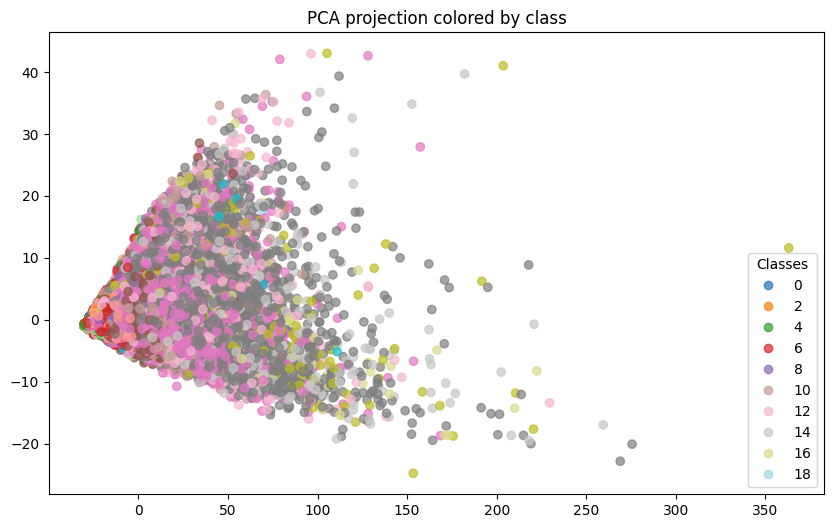

In [56]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab20', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('PCA projection colored by class')
plt.show()


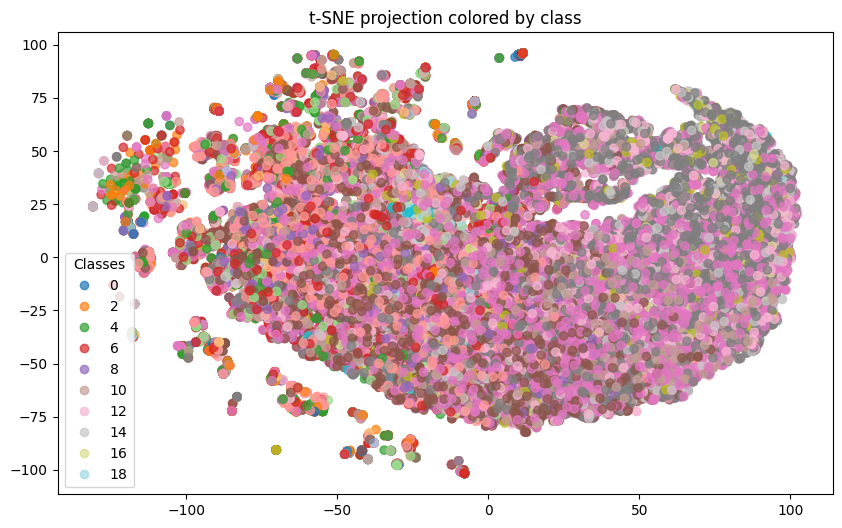

In [57]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10,6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab20', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('t-SNE projection colored by class')
plt.show()

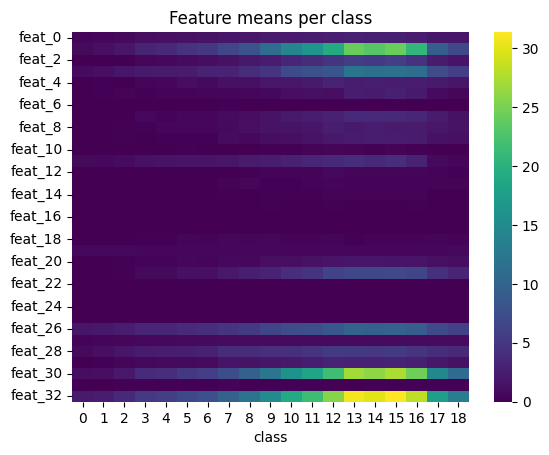

In [58]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(X, columns=[f'feat_{i}' for i in range(33)])
df['class'] = y

# Example: mean features per class
mean_per_class = df.groupby('class').mean()

sns.heatmap(mean_per_class.T, cmap='viridis')
plt.title('Feature means per class')
plt.show()

# Training the model

In [59]:
import json
import pandas as pd

# read features_list from the file
with open(f"splits_train/features_list_train.json", "r", encoding="utf-8") as f:
    train_features_list = json.load(f)

with open(f"splits_validation/features_list_validation.json", "r", encoding="utf-8") as f:
    eval_features_list = json.load(f)

with open(f"splits_test/features_list_test.json", "r", encoding="utf-8") as f:
    test_features_list = json.load(f)


# If train_dataset is not a DataFrame already, convert it
if not isinstance(train_dataset, pd.DataFrame):
    df_train = pd.DataFrame(train_dataset)
else:
    df_train = train_dataset.copy()

if not isinstance(test_dataset, pd.DataFrame):
    df_test = pd.DataFrame(test_dataset)
else:
    df_test = test_dataset.copy()

if not isinstance(eval_dataset, pd.DataFrame):
    df_eval = pd.DataFrame(eval_dataset)
else:
    df_eval = eval_dataset.copy()

# Build DataFrame from successfully parsed blocks
df_feats_train = pd.DataFrame(train_features_list)
df_feats_eval = pd.DataFrame(eval_features_list)
df_feats_test = pd.DataFrame(test_features_list)

# Ensure df_train has both Sentence and labels columns
assert "Sentence" in df_train.columns and "labels" in df_train.columns

# Ensure df_eval has both Sentence and labels columns
assert "Sentence" in df_eval.columns and "labels" in df_eval.columns

# Ensure df_test has both Sentence and labels columns
assert "Sentence" in df_test.columns and "labels" in df_test.columns

# Merge original dataset with features and keep labels, should have dataset as the one to merge on
merged_df_train = df_feats_train.merge(df_train[["Sentence", "labels"]], on="Sentence", how="right")
merged_df_eval = df_feats_eval.merge(df_eval[["Sentence", "labels"]], on="Sentence", how="right")
merged_df_test = df_feats_test.merge(df_test[["Sentence", "labels"]], on="Sentence", how="right")

In [61]:
print(merged_df_train.shape, merged_df_eval.shape, merged_df_test.shape)
print(train_dataset.shape, eval_dataset.shape, test_dataset.shape)

(54845, 35) (7310, 35) (7286, 35)
(54845, 16) (7310, 16) (7286, 16)


In [62]:
# saved merged_df_train to a file
merged_df_train.to_csv(f"./splits_train/merged_df_train.csv", index=False)
merged_df_eval.to_csv(f"./splits_validation/merged_df_eval.csv", index=False)
merged_df_test.to_csv(f"./splits_test/merged_df_test.csv", index=False)

In [64]:
import numpy as np
from sklearn.preprocessing import StandardScaler

X_train = merged_df_train.drop(columns=["Sentence", "labels"]).values
Y_train = merged_df_train["labels"].values

# Normalize features
scaler = StandardScaler()

X_test = merged_df_test.drop(columns=["Sentence", "labels"]).values
Y_test = merged_df_test["labels"].values

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Drop rows with Y_train = NaN
# nan_mask_train = ~np.isnan(Y_train)
# Y_train = Y_train[nan_mask_train]
# X_train = X_train[nan_mask_train]

# # Drop rows with Y_test = NaN
# nan_mask_test = ~np.isnan(Y_test)
# Y_test = Y_test[nan_mask_test]
# X_test = X_test[nan_mask_test]


# Train a Random Forest classifier

In [118]:
# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(X_train_scaled, Y_train)

y_pred = clf.predict(X_test_scaled)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.17      0.28        47
           1       0.11      0.03      0.04        36
           2       0.86      0.93      0.90      1016
           3       0.47      0.42      0.44        86
           4       0.28      0.32      0.30       392
           5       0.46      0.32      0.38       175
           6       0.30      0.42      0.35       626
           7       0.41      0.46      0.44       550
           8       0.36      0.14      0.20       190
           9       0.39      0.60      0.47      1012
          10       0.21      0.11      0.14       473
          11       0.32      0.31      0.31      1692
          12       0.29      0.06      0.10       440
          13       0.38      0.52      0.44      1049
          14       0.14      0.01      0.01       273
          15       0.00      0.00      0.00       161
          16       0.00      0.00      0.00        67
          17       0.00    

/opt/homebrew/anaconda3/envs/camel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/camel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/camel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [119]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, mean_absolute_error
import numpy as np

# Must be lists of ints
aligned_labels = Y_test.tolist()
aligned_predictions = y_pred.tolist()

# Add one to match 1-indexed
aligned_labels = [l + 1 for l in Y_test.tolist()]
aligned_predictions = [p + 1 for p in y_pred.tolist()]

# Accuracy
acc = accuracy_score(aligned_labels, aligned_predictions)

# Accuracy with margin of 1 level
acc_margin_1 = np.mean([abs(p - l) <= 1 for p, l in zip(aligned_predictions, aligned_labels)])

# Average absolute distance
avg_abs_dist = mean_absolute_error(aligned_labels, aligned_predictions)

# Quadratic Cohen's Kappa
qwk = cohen_kappa_score(aligned_labels, aligned_predictions, weights='quadratic')

# Accuracy for 7, 5, 3 levels
barec_7_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 3, 9: 3, 10: 4, 11: 4, 12: 5, 13: 5, 14: 6, 15: 6, 16: 7, 17: 7, 18: 7, 19: 7}
barec_5_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2, 10: 2, 11: 2, 12: 3, 13: 3, 14: 4, 15: 4, 16: 5, 17: 5, 18: 5, 19: 5}
barec_3_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 2, 13: 2, 14: 3, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3}

aligned_labels_7 = [barec_7_dict[l] for l in aligned_labels]
aligned_predictions_7 = [barec_7_dict[p] for p in aligned_predictions]
acc_7 = accuracy_score(aligned_labels_7, aligned_predictions_7)

aligned_labels_5 = [barec_5_dict[l] for l in aligned_labels]
aligned_predictions_5 = [barec_5_dict[p] for p in aligned_predictions]
acc_5 = accuracy_score(aligned_labels_5, aligned_predictions_5)

aligned_labels_3 = [barec_3_dict[l] for l in aligned_labels]
aligned_predictions_3 = [barec_3_dict[p] for p in aligned_predictions]
acc_3 = accuracy_score(aligned_labels_3, aligned_predictions_3)

print(f"Accuracy: {acc*100:.4f}%")
print(f"Accuracy +/-1: {acc_margin_1*100:.4f}%")
print(f"Average absolute distance: {avg_abs_dist:.6f}")
print(f"Quadratic Cohen's Kappa: {qwk*100:.4f}%")
print(f"Accuracy (7 levels): {acc_7*100:.4f}%")
print(f"Accuracy (5 levels): {acc_5*100:.4f}%")
print(f"Accuracy (3 levels): {acc_3*100:.4f}%")


Accuracy: 41.6747%
Accuracy +/-1: 52.7991%
Average absolute distance: 1.750841
Quadratic Cohen's Kappa: 74.1841%
Accuracy (7 levels): 50.0000%
Accuracy (5 levels): 56.1269%
Accuracy (3 levels): 62.8664%


# Using DeepNN

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

# Dataset and Dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)

# Define more complex model
class DeepNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Model, loss, optimizer
input_dim = X_train.shape[1]
num_classes = len(np.unique(Y_train))
model = DeepNN(input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training with validation
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == yb).sum().item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_correct/len(val_subset):.4f}")

# Test evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(yb.numpy())

print(classification_report(all_labels, all_preds))

Epoch 1/20 - Train Loss: 3308.1045, Val Loss: 341.2925, Val Acc: 0.3443
Epoch 2/20 - Train Loss: 3163.6501, Val Loss: 335.2125, Val Acc: 0.3476
Epoch 3/20 - Train Loss: 3137.1842, Val Loss: 334.3613, Val Acc: 0.3537
Epoch 4/20 - Train Loss: 3115.3689, Val Loss: 330.1125, Val Acc: 0.3497
Epoch 5/20 - Train Loss: 3088.4920, Val Loss: 330.7316, Val Acc: 0.3629
Epoch 6/20 - Train Loss: 3083.6970, Val Loss: 328.4067, Val Acc: 0.3558
Epoch 7/20 - Train Loss: 3071.0088, Val Loss: 326.5810, Val Acc: 0.3591
Epoch 8/20 - Train Loss: 3061.9948, Val Loss: 325.6469, Val Acc: 0.3601
Epoch 9/20 - Train Loss: 3050.6133, Val Loss: 323.6111, Val Acc: 0.3615
Epoch 10/20 - Train Loss: 3043.7018, Val Loss: 322.7374, Val Acc: 0.3687
Epoch 11/20 - Train Loss: 3038.3043, Val Loss: 322.3677, Val Acc: 0.3700
Epoch 12/20 - Train Loss: 3032.6733, Val Loss: 322.4419, Val Acc: 0.3661
Epoch 13/20 - Train Loss: 3025.8294, Val Loss: 322.0981, Val Acc: 0.3621
Epoch 14/20 - Train Loss: 3020.0711, Val Loss: 320.9201, Val

/opt/homebrew/anaconda3/envs/camel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/camel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/camel/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [97]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, mean_absolute_error
import numpy as np

# Must be lists of ints
aligned_labels = Y_test.tolist()
aligned_predictions = y_pred.tolist()

# Add one to match 1-indexed
aligned_labels = [l + 1 for l in Y_test.tolist()]
aligned_predictions = [p + 1 for p in y_pred.tolist()]

# Accuracy
acc = accuracy_score(aligned_labels, aligned_predictions)

# Accuracy with margin of 1 level
acc_margin_1 = np.mean([abs(p - l) <= 1 for p, l in zip(aligned_predictions, aligned_labels)])

# Average absolute distance
avg_abs_dist = mean_absolute_error(aligned_labels, aligned_predictions)

# Quadratic Cohen's Kappa
qwk = cohen_kappa_score(aligned_labels, aligned_predictions, weights='quadratic')

# Accuracy for 7, 5, 3 levels
barec_7_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 3, 9: 3, 10: 4, 11: 4, 12: 5, 13: 5, 14: 6, 15: 6, 16: 7, 17: 7, 18: 7, 19: 7}
barec_5_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2, 10: 2, 11: 2, 12: 3, 13: 3, 14: 4, 15: 4, 16: 5, 17: 5, 18: 5, 19: 5}
barec_3_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 2, 13: 2, 14: 3, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3}

aligned_labels_7 = [barec_7_dict[l] for l in aligned_labels]
aligned_predictions_7 = [barec_7_dict[p] for p in aligned_predictions]
acc_7 = accuracy_score(aligned_labels_7, aligned_predictions_7)

aligned_labels_5 = [barec_5_dict[l] for l in aligned_labels]
aligned_predictions_5 = [barec_5_dict[p] for p in aligned_predictions]
acc_5 = accuracy_score(aligned_labels_5, aligned_predictions_5)

aligned_labels_3 = [barec_3_dict[l] for l in aligned_labels]
aligned_predictions_3 = [barec_3_dict[p] for p in aligned_predictions]
acc_3 = accuracy_score(aligned_labels_3, aligned_predictions_3)

print(f"Accuracy: {acc*100:.4f}%")
print(f"Accuracy +/-1: {acc_margin_1*100:.4f}%")
print(f"Average absolute distance: {avg_abs_dist:.6f}")
print(f"Quadratic Cohen's Kappa: {qwk*100:.4f}%")
print(f"Accuracy (7 levels): {acc_7*100:.4f}%")
print(f"Accuracy (5 levels): {acc_5*100:.4f}%")
print(f"Accuracy (3 levels): {acc_3*100:.4f}%")


Accuracy: 41.8529%
Accuracy +/-1: 52.9440%
Average absolute distance: 1.754025
Quadratic Cohen's Kappa: 74.2297%
Accuracy (7 levels): 50.0961%
Accuracy (5 levels): 56.1404%
Accuracy (3 levels): 62.7253%


# Model for dependency parsing output 

In [8]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import math

# Step 1: Define Token and ParsedSentence classes
class Token:
    def __init__(self, idx, form, lemma, upos, xpos, feats_str, head, deprel):
        self.idx = int(idx)
        self.form = form
        self.lemma = lemma
        self.upos = upos
        self.xpos = xpos
        self.feats = self.parse_feats(feats_str)
        self.head = int(head)
        self.deprel = deprel

    def parse_feats(self, feats_str):
        # feats_str looks like: ud=NOUN|pos=noun|prc3=0|...
        feats = {}
        for feat in feats_str.split('|'):
            if '=' in feat:
                k, v = feat.split('=', 1)
                feats[k] = v
        return feats

class ParsedSentence:
    def __init__(self, tokens):
        self.tokens = tokens

# Step 2: Load data from file
def load_parsed_sentences(filename, merged_df_train):
    labels = []
    sentences = []
    raw_sentences = []
    current_tokens = []
    reading_sentence = False

    with open(filename, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.startswith("# text ="):
                # take raw sentence after "# text = "
                raw_sentence = line[len("# text = "):].strip()
                labels_got = merged_df_train[merged_df_train['Sentence'] == clean_sentence(raw_sentence)]['labels'].values
                if (
                    len(labels_got) == 0 or
                    labels_got[0] is None or
                    isinstance(labels_got[0], float) and math.isnan(labels_got[0])
                ):
                    # No label found for this sentence, Will skip entire sentence
                    continue
                labels.append(labels_got[0])
                raw_sentences.append(raw_sentence)
                # Start a new sentence on next lines
                if current_tokens:
                    sentences.append(ParsedSentence(current_tokens))
                    current_tokens = []
                reading_sentence = True
                continue
            if reading_sentence:
                if line == "":
                    # End of sentence block
                    if current_tokens:
                        sentences.append(ParsedSentence(current_tokens))
                        current_tokens = []
                    reading_sentence = False
                    continue
                # parse token line
                fields = line.split('\t')
                if len(fields) < 8:
                    continue  # skip malformed lines
                idx, form, lemma, upos, xpos, feats_str, head, deprel = fields[:8]
                token = Token(idx, form, lemma, upos, xpos, feats_str, head, deprel)
                current_tokens.append(token)

        # Append last sentence if any
        if current_tokens:
            sentences.append(ParsedSentence(current_tokens))

    if len(sentences) != len(labels):
        raise ValueError(f"Number of sentences ({len(sentences)}) does not match number of labels ({len(labels)})")
    return sentences, labels, raw_sentences

# Step 3: Vocabulary class (from earlier)
class Vocab:
    def __init__(self, add_unk=True):
        self.token2id = {}
        self.id2token = {}
        self.add_unk = add_unk
        self.unk_token = "<UNK>"
        self.next_id = 0
        if add_unk:
            self.add_token(self.unk_token)

    def add_token(self, token):
        if token not in self.token2id:
            self.token2id[token] = self.next_id
            self.id2token[self.next_id] = token
            self.next_id += 1
        return self.token2id[token]

    def get_id(self, token):
        if token in self.token2id:
            return self.token2id[token]
        elif self.add_unk:
            return self.token2id[self.unk_token]
        else:
            raise KeyError(f"Token '{token}' not in vocabulary and add_unk=False")

    def __len__(self):
        return self.next_id

# Step 4: Build vocabularies
def build_vocabs(sentences):
    upos_vocab = Vocab()
    deprel_vocab = Vocab()
    morph_feat_vocabs = {}

    # Collect all morph feature keys
    morph_keys = set()
    for ps in sentences:
        for t in ps.tokens:
            morph_keys.update(t.feats.keys())
    morph_keys = sorted(morph_keys)

    # Initialize morph vocabularies
    for k in morph_keys:
        morph_feat_vocabs[k] = Vocab()

    # Fill vocabs
    for ps in sentences:
        for t in ps.tokens:
            upos_vocab.add_token(t.upos)
            deprel_vocab.add_token(t.deprel)
            for k in morph_keys:
                val = t.feats.get(k, None)
                if val is None:
                    morph_feat_vocabs[k].add_token(morph_feat_vocabs[k].unk_token)
                else:
                    morph_feat_vocabs[k].add_token(val)

    return upos_vocab, deprel_vocab, morph_feat_vocabs, morph_keys

# Step 5: Vectorize token
def vectorize_token(token, upos_vocab, deprel_vocab, morph_feat_vocabs, morph_keys):
    upos_id = upos_vocab.get_id(token.upos)
    deprel_id = deprel_vocab.get_id(token.deprel)
    morph_feat_ids = []
    for key in morph_keys:
        val = token.feats.get(key, None)
        if val is None:
            morph_feat_ids.append(morph_feat_vocabs[key].get_id(morph_feat_vocabs[key].unk_token))
        else:
            morph_feat_ids.append(morph_feat_vocabs[key].get_id(val))
    return upos_id, deprel_id, morph_feat_ids

# Step 6: Dataset
from torch.utils.data import Dataset

class DependencyParsingDataset(Dataset):
    def __init__(self, parsed_sentences, labels, raw_sentences, upos_vocab, deprel_vocab, morph_feat_vocabs, morph_keys):
        self.sentences = parsed_sentences   # list of ParsedSentence objects
        self.labels = labels                 # list of labels corresponding to sentences
        self.raw_sentences = raw_sentences  # list of raw sentences
        self.upos_vocab = upos_vocab
        self.deprel_vocab = deprel_vocab
        self.morph_feat_vocabs = morph_feat_vocabs
        self.morph_keys = morph_keys

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        ps = self.sentences[idx]
        labels = self.labels[idx]
        token_features = []
        heads = []
        deprels = []
        for t in ps.tokens:
            upos_id, deprel_id, morph_feat_ids = vectorize_token(
                t, self.upos_vocab, self.deprel_vocab, self.morph_feat_vocabs, self.morph_keys
            )
            token_features.append([upos_id] + morph_feat_ids)
            heads.append(t.head)
            deprels.append(deprel_id)

        token_features = torch.tensor(token_features, dtype=torch.long)
        heads = torch.tensor(heads, dtype=torch.long)
        deprels = torch.tensor(deprels, dtype=torch.long)
        # Convert labels to tensor
        labels = torch.tensor(labels, dtype=torch.long) if isinstance(labels, (list, np.ndarray)) else torch.tensor([labels], dtype=torch.long)
        
        # Return also the raw sentence so you can join with labels outside
        return token_features, heads, deprels, labels

# Step 7: Collate function for padding batches
def collate_fn(batch):
    batch_token_feats = [x[0] for x in batch]
    batch_heads = [x[1] for x in batch]
    batch_deprels = [x[2] for x in batch]
    batch_labels = [x[3] for x in batch]

    max_len = max([x.shape[0] for x in batch_token_feats])

    def pad_tensor(tensor, max_len):
        pad_size = max_len - tensor.shape[0]
        if pad_size > 0:
            pad_tensor = torch.zeros((pad_size, tensor.shape[1]), dtype=torch.long)
            return torch.cat([tensor, pad_tensor], dim=0)
        return tensor

    padded_feats = torch.stack([pad_tensor(t, max_len) for t in batch_token_feats])
    padded_heads = torch.stack([torch.cat([h, torch.full((max_len - h.size(0),), -1, dtype=torch.long)]) if max_len > h.size(0) else h for h in batch_heads])
    padded_deprels = torch.stack([torch.cat([d, torch.full((max_len - d.size(0),), -1, dtype=torch.long)]) if max_len > d.size(0) else d for d in batch_deprels])
    labels_tensor = torch.stack(batch_labels)  # ✅ Combine labels into a tensor

    labels_tensor = labels_tensor.squeeze(1)  # Remove extra dimension if needed
    return padded_feats, padded_heads, padded_deprels, labels_tensor

# Step 8: Define the simple model (from earlier)
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleDepParser(nn.Module):
    def __init__(self, upos_vocab_size, morph_feat_vocab_sizes, embedding_dim=16, hidden_dim=32, morph_feat_dim=8, num_labels=3):
        super().__init__()
        self.upos_embedding = nn.Embedding(upos_vocab_size, embedding_dim)
        self.morph_feat_embeddings = nn.ModuleList([
            nn.Embedding(vsize, morph_feat_dim) for vsize in morph_feat_vocab_sizes
        ])

        input_dim = embedding_dim + morph_feat_dim * len(morph_feat_vocab_sizes)
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)

        # For dependency parsing
        self.head_scorer = nn.Linear(hidden_dim * 2, hidden_dim)  # not used if you ignore heads

        # For sentence classification (e.g., difficulty)
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, token_feats):
        upos_ids = token_feats[:, :, 0]
        morph_feats_ids = token_feats[:, :, 1:]

        upos_emb = self.upos_embedding(upos_ids)
        morph_embs = [emb_layer(morph_feats_ids[:, :, i]) for i, emb_layer in enumerate(self.morph_feat_embeddings)]
        morph_emb = torch.cat(morph_embs, dim=-1)

        x = torch.cat([upos_emb, morph_emb], dim=-1)  # (batch, seq_len, input_dim)

        enc_out, _ = self.encoder(x)  # (batch, seq_len, hidden_dim * 2)

        # Sentence-level representation (mean pooling)
        sent_repr = enc_out.mean(dim=1)  # (batch, hidden_dim * 2)

        # Sentence classification output
        sentence_logits = self.classifier(sent_repr)  # (batch, num_labels)

        return enc_out, sentence_logits


In [10]:
# load merged_df_train 
import pandas as pd
import numpy as np
merged_df_train = pd.read_csv("./splits_train/merged_df_train.csv")
merged_df_eval = pd.read_csv("./splits_validation/merged_df_eval.csv")
merged_df_test = pd.read_csv("./splits_test/merged_df_test.csv")

In [249]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


# Load data
filename_train = "./splits_train/all_parsed_blocks.txt"
train_sentences, train_labels, train_raw_sentences = load_parsed_sentences(filename_train, merged_df_train)

filename_eval = "splits_validation/all_parsed_blocks_validation.txt"
val_sentences, val_labels, val_raw_sentences = load_parsed_sentences(filename_eval, merged_df_eval)

filename_test = "splits_test/all_parsed_blocks_test.txt"
test_sentences, test_labels, test_raw_sentences = load_parsed_sentences(filename_test, merged_df_test)


# Build vocabularies
upos_vocab, deprel_vocab, morph_feat_vocabs, morph_keys = build_vocabs(train_sentences)
morph_feat_vocab_sizes = [len(morph_feat_vocabs[k]) for k in morph_keys]


train_dataset = DependencyParsingDataset(train_sentences, train_labels, train_raw_sentences, upos_vocab, deprel_vocab, morph_feat_vocabs, morph_keys)
val_dataset = DependencyParsingDataset(val_sentences, val_labels, val_raw_sentences, upos_vocab, deprel_vocab, morph_feat_vocabs, morph_keys)
test_dataset = DependencyParsingDataset(test_sentences, test_labels, test_raw_sentences, upos_vocab, deprel_vocab, morph_feat_vocabs, morph_keys)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleDepParser(len(upos_vocab), morph_feat_vocab_sizes, num_labels=19).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

def evaluate(dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for token_feats, _, _, labels in dataloader:
            labels = labels.to(dtype=torch.long, device=device)
            token_feats = token_feats.to(device)
            _, sentence_logits = model(token_feats)
            loss = F.cross_entropy(sentence_logits, labels)
            total_loss += loss.item()
    return total_loss / len(dataloader)

def train_epoch():
    model.train()
    total_loss = 0
    for token_feats, _, _, labels in train_loader:
        labels = labels.to(dtype=torch.long, device=device)
        token_feats = token_feats.to(device)

        optimizer.zero_grad()

        _, sentence_logits = model(token_feats)
        
        loss = F.cross_entropy(sentence_logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

for epoch in range(5):
    train_loss = train_epoch()
    val_loss = evaluate(val_loader)
    print(f"Epoch {epoch+1} train loss: {train_loss:.4f} val loss: {val_loss:.4f}")

/var/folders/dq/xr1b36h54wq7k53g71c_lvnh0000gn/T/ipykernel_41557/1100307821.py:192: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.tensor(labels, dtype=torch.long) if isinstance(labels, (list, np.ndarray)) else torch.tensor([labels], dtype=torch.long)


Epoch 1 train loss: 2.1511 val loss: 2.2161
Epoch 2 train loss: 1.9520 val loss: 2.0826
Epoch 3 train loss: 1.8842 val loss: 2.0432
Epoch 4 train loss: 1.8334 val loss: 1.9541
Epoch 5 train loss: 1.7990 val loss: 1.9234


In [250]:
def predict(parsed_sentences_list, raw_sentences):
    model.eval()
    preds = []
    with torch.no_grad():
        # We don't have labels during prediction, so just pass dummy labels (e.g., zeros)
        dummy_labels = [0] * len(parsed_sentences_list)
        dataset = DependencyParsingDataset(parsed_sentences_list, dummy_labels, raw_sentences, upos_vocab, deprel_vocab, morph_feat_vocabs, morph_keys)
        loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
        
        for token_feats, heads, deprels, labels in loader:
            token_feats = token_feats.to(device)
            _, logits = model(token_feats)
            predicted_labels = torch.argmax(logits, dim=1)
            preds.extend(predicted_labels.cpu().tolist())
    
    # Convert predictions to original label space by adding 1 (if needed)
    preds = [p + 1 for p in preds]  # Assuming labels are
    return preds

predictions = predict(test_sentences, test_raw_sentences)
real_labels = []
for sent, pred in zip(test_sentences, predictions):
    # You can print the raw sentence string if you have it stored, or reconstruct from tokens
    raw_sentence = test_raw_sentences[test_sentences.index(sent)]
    # print(f"Sentence: {raw_sentence}")
    # print(f"Predicted label: {pred}")
    labels_got = merged_df_test[merged_df_test['Sentence'] == clean_sentence(raw_sentence)]['labels'].values
    if (
        len(labels_got) == 0 or
        labels_got[0] is None or
        isinstance(labels_got[0], float) and math.isnan(labels_got[0])
    ):
        # No label found for this sentence, Will skip entire sentence
        real_label = 13
    else:
        real_label = labels_got[0]

    real_labels.append(real_label)


In [251]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, mean_absolute_error
import numpy as np

# Must be lists of ints
aligned_labels = predictions
aligned_predictions = real_labels

# Add one to match 1-indexed
aligned_labels = [l + 1 for l in aligned_labels]
aligned_predictions = [p + 1 for p in aligned_predictions]

# Accuracy
acc = accuracy_score(aligned_labels, aligned_predictions)

# Accuracy with margin of 1 level
acc_margin_1 = np.mean([abs(p - l) <= 1 for p, l in zip(aligned_predictions, aligned_labels)])

# Average absolute distance
avg_abs_dist = mean_absolute_error(aligned_labels, aligned_predictions)

# Quadratic Cohen's Kappa
qwk = cohen_kappa_score(aligned_labels, aligned_predictions, weights='quadratic')

# Accuracy for 7, 5, 3 levels
barec_7_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 3, 9: 3, 10: 4, 11: 4, 12: 5, 13: 5, 14: 6, 15: 6, 16: 7, 17: 7, 18: 7, 19: 7}
barec_5_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2, 10: 2, 11: 2, 12: 3, 13: 3, 14: 4, 15: 4, 16: 5, 17: 5, 18: 5, 19: 5}
barec_3_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 2, 13: 2, 14: 3, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3}

aligned_labels_7 = [barec_7_dict[l] for l in aligned_labels]
aligned_predictions_7 = [barec_7_dict[p] for p in aligned_predictions]
acc_7 = accuracy_score(aligned_labels_7, aligned_predictions_7)

aligned_labels_5 = [barec_5_dict[l] for l in aligned_labels]
aligned_predictions_5 = [barec_5_dict[p] for p in aligned_predictions]
acc_5 = accuracy_score(aligned_labels_5, aligned_predictions_5)

aligned_labels_3 = [barec_3_dict[l] for l in aligned_labels]
aligned_predictions_3 = [barec_3_dict[p] for p in aligned_predictions]
acc_3 = accuracy_score(aligned_labels_3, aligned_predictions_3)

print(f"Accuracy: {acc*100:.4f}%")
print(f"Accuracy +/-1: {acc_margin_1*100:.4f}%")
print(f"Average absolute distance: {avg_abs_dist:.6f}")
print(f"Quadratic Cohen's Kappa: {qwk*100:.4f}%")
print(f"Accuracy (7 levels): {acc_7*100:.4f}%")
print(f"Accuracy (5 levels): {acc_5*100:.4f}%")
print(f"Accuracy (3 levels): {acc_3*100:.4f}%")


Accuracy: 4.0825%
Accuracy +/-1: 23.1721%
Average absolute distance: 4.113087
Quadratic Cohen's Kappa: 4.1092%
Accuracy (7 levels): 20.5548%
Accuracy (5 levels): 20.5548%
Accuracy (3 levels): 24.3812%


# Trying GNN architecture

In [13]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch
from sklearn.model_selection import train_test_split
import math


# load merged_df_train 
import pandas as pd
import numpy as np
merged_df_train = pd.read_csv("./splits_train/merged_df_train.csv")
merged_df_eval = pd.read_csv("./splits_validation/merged_df_eval.csv")
merged_df_test = pd.read_csv("./splits_test/merged_df_test.csv")

import re
# try to remove all non arabic stuff :)
def clean_sentence(sentence):
    # Arabic characters range: main + extended + some punctuation
    arabic_pattern = re.compile(r'[\u0600-\u06FF]+')

    # Extract all Arabic tokens
    arabic_tokens = arabic_pattern.findall(sentence)

    sentence = " ".join(arabic_tokens)

    # If sentence ends with arabic comma '،', remove it because it mess up with dependency parsing
    if sentence.endswith('،'):
        sentence = sentence[:-1].strip()
        
    # Join with space to reconstruct a clean sentence
    return sentence

# Load data
filename_train = "./splits_train/all_parsed_blocks.txt"
train_sentences, train_labels, train_raw_sentences = load_parsed_sentences(filename_train, merged_df_train)

filename_val = "splits_validation/all_parsed_blocks_validation.txt"
val_sentences, val_labels, val_raw_sentences = load_parsed_sentences(filename_val, merged_df_eval)

filename_test = "splits_test/all_parsed_blocks_test.txt"
test_sentences, test_labels, test_raw_sentences = load_parsed_sentences(filename_test, merged_df_test)

In [14]:
import fasttext
import fasttext.util


# fasttext.util.download_model('ar', if_exists='ignore')  # English
ft = fasttext.load_model('cc.ar.300.bin')

print("ft.get_dimension()", ft.get_dimension())

# fasttext.util.reduce_model(ft, 100)
# print("ft.get_dimension()", ft.get_dimension())

ft.get_dimension() 300


In [35]:
from torch_geometric.data import Data
import torch
import numpy as np

def get_embedding(word):
    try:
        return ft.get_word_vector(word)
    except KeyError:
        return np.zeros(ft.get_dimension(), dtype=np.float32)

def extract_pos_and_morph_vocab(parsed_sentences):
    pos_set = set()
    morph_set = set()

    for sent in parsed_sentences:
        for tok in sent["tokens"]:
            # Collect POS tags
            pos_set.add(tok["pos"])
            # Collect morphological features
            for feat, val in tok["morph"].items():
                morph_set.add(f"{feat}={val}")

    pos_vocab = {pos: idx for idx, pos in enumerate(sorted(pos_set))}
    morph_vocab = {feat: idx for idx, feat in enumerate(sorted(morph_set))}
    
    return pos_vocab, morph_vocab

def parse_conllu_file(path):
    def parse_morph_features(feat_str):
        if feat_str == "_" or feat_str.strip() == "":
            return {}
        return dict(item.split("=") for item in feat_str.split("|") if "=" in item)

    with open(path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    sentences = []
    current = {"text": "", "tokens": []}

    for line in lines:
        if line.startswith("# text ="):
            current["text"] = line.strip().replace("# text = ", "")
        elif line.strip() == "":
            if current["tokens"]:
                sentences.append(current)
            current = {"text": "", "tokens": []}
        elif not line.startswith("#"):
            parts = line.strip().split("\t")
            if "-" in parts[0] or "." in parts[0] or len(parts) < 10:
                continue
            head = parts[6]  
            deprel = parts[7]
            tok = {
                "id": int(parts[0]),
                "form": parts[1],
                "lemma": parts[2],
                "pos": parts[3],
                "morph": parse_morph_features(parts[5]),
                "head": int(head) if head.isdigit() else 0,
                "deprel": deprel
            }
            current["tokens"].append(tok)

    return sentences

import torch
from torch_geometric.data import Data

# Utilities for feature encoding
def one_hot_pos(pos_tag, pos_vocab):
    vec = [0] * len(pos_vocab)
    if pos_tag in pos_vocab:
        vec[pos_vocab[pos_tag]] = 1
    return vec

def multi_hot_morph(morph_dict, morph_vocab):
    vec = [0] * len(morph_vocab)
    for feat, val in morph_dict.items():
        key = f"{feat}={val}"
        if key in morph_vocab:
            vec[morph_vocab[key]] = 1
    return vec

def parse_sentence_to_graph(parsed_sent, label_map, pos_vocab, morph_vocab, emb_dim=300):
    conllu_tokens = parsed_sent["tokens"]
    text = parsed_sent["text"]

    node_features = []
    edge_index = [[], []]
    total_tokens = len(conllu_tokens)

    for i, tok in enumerate(conllu_tokens):
        # 1. Embedding
        emb = get_embedding(tok["form"])  # shape: [300]

        # 2. POS one-hot
        pos_vec = one_hot_pos(tok["pos"], pos_vocab)

        # 3. Morphological multi-hot
        morph_vec = multi_hot_morph(tok["morph"], morph_vocab)

        # 4. Normalized position
        position = [tok["id"] / total_tokens]

        # Combine all
        full_feature = np.concatenate([emb, pos_vec, morph_vec, position])
        node_features.append(full_feature)

        # Edges (from head to dependent)
        if tok["head"] != 0:
            edge_index[0].append(tok["head"] - 1)
            edge_index[1].append(tok["id"] - 1)

    if text not in label_map:
        return None

    return Data(
        x=torch.tensor(node_features, dtype=torch.float),
        edge_index=torch.tensor(edge_index, dtype=torch.long),
        y=torch.tensor([label_map[text]], dtype=torch.long),
        sentence=text
    )


In [36]:
import pandas as pd

# Load labels file
df_labels_train = pd.read_csv("splits_train/merged_df_train.csv")
df_labels_test = pd.read_csv("splits_test/merged_df_test.csv")

# Build map
label_map_train = dict(zip(df_labels_train["Sentence"], df_labels_train["labels"]))
label_map_test = dict(zip(df_labels_test["Sentence"], df_labels_test["labels"]))

# Parse CONLL-U file
parsed_sentences_train = parse_conllu_file("splits_train/all_parsed_blocks.txt")
parsed_sentences_test = parse_conllu_file("splits_test/all_parsed_blocks_test.txt")

# Combine both if needed
all_parsed = parsed_sentences_train + parsed_sentences_test
pos_vocab, morph_vocab = extract_pos_and_morph_vocab(all_parsed)

# Convert all to graph data
graph_data_list_train = [
    parse_sentence_to_graph(sent, label_map_train, pos_vocab, morph_vocab)
    for sent in parsed_sentences_train
]
graph_data_list_test = [
    parse_sentence_to_graph(sent, label_map_test, pos_vocab, morph_vocab)
    for sent in parsed_sentences_test
]

graph_data_list_train = [g for g in graph_data_list_train if g is not None]
graph_data_list_test = [g for g in graph_data_list_test if g is not None]


/var/folders/dq/xr1b36h54wq7k53g71c_lvnh0000gn/T/ipykernel_809/4063621001.py:120: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y=torch.tensor([label_map[text]], dtype=torch.long),


In [37]:
graph_data_list_train[3]

Data(x=[4, 412], edge_index=[2, 3], y=[1], sentence='الموافق جمادى الأول هــ')

In [38]:
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
import torch.nn as nn

class GCNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)  # added extra GCN layer
        
        self.fc1 = nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc2 = nn.Linear(hidden_channels // 2, num_classes)
        
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch if hasattr(data, 'batch') else None
        
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = F.relu(self.conv3(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Use global pooling if batching multiple graphs
        if batch is not None:
            x = global_mean_pool(x, batch)  # aggregate node features to graph features
        else:
            x = torch.mean(x, dim=0, keepdim=True)  # if single graph, mean over nodes
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.fc2(x)
        return x


In [41]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

# Suppose graph_data_list is your full dataset list of Data objects

# 1. Split into train and validation (90%, 10%)
train_graphs, val_graphs = train_test_split(graph_data_list_train, test_size=0.1, random_state=42, shuffle=True)


# 2. Create data loaders
train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=1, shuffle=False)

# 3. If you have a test set, create a test loader
test_loader = DataLoader(graph_data_list_test, batch_size=1, shuffle=False)

# 3. Define model, optimizer, criterion
model = GCNClassifier(in_channels=412, hidden_channels=128, num_classes=19)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 4. Training loop
for epoch in range(5):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)  # shape [num_classes]
        loss = criterion(out, data.y)  # add batch dim
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: Train Loss = {total_loss:.4f}")
    # 5. Testing loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            out = model(data)  # [num_classes]
            pred = out.argmax().item()
            label = data.y.item()
            if pred == label:
                correct += 1
            total += 1
    print(f"Validation Accuracy: {correct}/{total} = {correct/total:.4f}")
    model.train()  # Reset to train mode for next epoch


Epoch 0: Train Loss = 96310.4110
Validation Accuracy: 1222/4759 = 0.2568
Epoch 1: Train Loss = 93890.3031
Validation Accuracy: 1443/4759 = 0.3032
Epoch 2: Train Loss = 93646.2756
Validation Accuracy: 1353/4759 = 0.2843
Epoch 3: Train Loss = 93464.5544
Validation Accuracy: 1453/4759 = 0.3053
Epoch 4: Train Loss = 94066.1429
Validation Accuracy: 1374/4759 = 0.2887


In [42]:
predictions = []
real_labels = []
sentences = []

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data)
        pred = out.argmax().item()
        label = data.y.item()
        predictions.append(pred)
        real_labels.append(label)
        sentences.append(data.sentence)  # 👈 access the sentence again

In [43]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, mean_absolute_error
import numpy as np

# Must be lists of ints
aligned_labels = predictions
aligned_predictions = real_labels

# Add one to match 1-indexed
aligned_labels = [l + 1 for l in aligned_labels]
aligned_predictions = [p + 1 for p in aligned_predictions]

# Accuracy
acc = accuracy_score(aligned_labels, aligned_predictions)

# Accuracy with margin of 1 level
acc_margin_1 = np.mean([abs(p - l) <= 1 for p, l in zip(aligned_predictions, aligned_labels)])

# Average absolute distance
avg_abs_dist = mean_absolute_error(aligned_labels, aligned_predictions)

# Quadratic Cohen's Kappa
qwk = cohen_kappa_score(aligned_labels, aligned_predictions, weights='quadratic')

# Accuracy for 7, 5, 3 levels
barec_7_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 3, 9: 3, 10: 4, 11: 4, 12: 5, 13: 5, 14: 6, 15: 6, 16: 7, 17: 7, 18: 7, 19: 7}
barec_5_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2, 10: 2, 11: 2, 12: 3, 13: 3, 14: 4, 15: 4, 16: 5, 17: 5, 18: 5, 19: 5}
barec_3_dict = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 2, 13: 2, 14: 3, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3}

aligned_labels_7 = [barec_7_dict[l] for l in aligned_labels]
aligned_predictions_7 = [barec_7_dict[p] for p in aligned_predictions]
acc_7 = accuracy_score(aligned_labels_7, aligned_predictions_7)

aligned_labels_5 = [barec_5_dict[l] for l in aligned_labels]
aligned_predictions_5 = [barec_5_dict[p] for p in aligned_predictions]
acc_5 = accuracy_score(aligned_labels_5, aligned_predictions_5)

aligned_labels_3 = [barec_3_dict[l] for l in aligned_labels]
aligned_predictions_3 = [barec_3_dict[p] for p in aligned_predictions]
acc_3 = accuracy_score(aligned_labels_3, aligned_predictions_3)

print(f"Accuracy: {acc*100:.4f}%")
print(f"Accuracy +/-1: {acc_margin_1*100:.4f}%")
print(f"Average absolute distance: {avg_abs_dist:.6f}")
print(f"Quadratic Cohen's Kappa: {qwk*100:.4f}%")
print(f"Accuracy (7 levels): {acc_7*100:.4f}%")
print(f"Accuracy (5 levels): {acc_5*100:.4f}%")
print(f"Accuracy (3 levels): {acc_3*100:.4f}%")


Accuracy: 29.4026%
Accuracy +/-1: 42.5462%
Average absolute distance: 2.047368
Quadratic Cohen's Kappa: 53.1631%
Accuracy (7 levels): 38.0939%
Accuracy (5 levels): 43.3286%
Accuracy (3 levels): 51.4794%
